# Fair share plot

All data comes from the Climate Action tracker by the NewClimate institute and Climate analytics (https://climateactiontracker.org/). 

Necessary imports

In [1]:
import urllib.request
import ssl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
ssl._create_default_https_context = ssl._create_unverified_context


Grab all the URLs for the source data

In [2]:
website='https://climateactiontracker.org/countries/%s/'

countries=['argentina','australia','bhutan','brazil','canada','chile','china',
            'colombia','costa-rica','eu','egypt','gabon','germany','india',
            'indonesia','iran','japan','kazakhstan','kenya','mexico','morocco',
            'nepal','new-zealand','nigeria','norway','peru','philippines',
            'russian-federation','saudi-arabia','singapore','south-africa',
            'south-korea','switzerland','thailand','gambia','turkey','uae',
            'usa','ukraine','uk','vietnam']

#make the country names nicer for labels
pages={country.replace('-',' ').title() if len(country)>3 else country.upper(): country for country in countries}
for country in pages:
    with urllib.request.urlopen(website%pages[country]) as response:
        content = response.readlines()
        for line in content:
            if b'xlsx' in line:
                pages[country]='https://climateactiontracker.org'+str(line[line.find(b'="')+2:-2].decode('utf-8'))

Function to retrieve the data from the xlsx files.

In [3]:
def getReduction(dls):
        
    urllib.request.urlretrieve(dls, "temp.xls")  # For Python 3
    xl = pd.ExcelFile('temp.xls')
    df=pd.read_excel(xl,'EffortSharing')
    try:
        row_index = df[df.eq("1.5°C Paris Agreement compatible").any(axis=1)].index[0]           #want to know which row this is found in
    except: 
        row_index = df[df.eq("1.5°C compatible").any(axis=1)].index[0]                           #some have it like this
    col_index = df.iloc[row_index-1].apply(pd.to_numeric, errors='coerce').eq(2030).idxmax() #want to know that in the row above 
                                                                                             #which column belongs to 2030
    
    fair2030 = df[col_index].iloc[row_index]
    
    df=pd.read_excel(xl,'Assessment') 
    row_index = df[df.eq("Historical emissions, excl forestry").any(axis=1)].index[0]

    year=2022
    col_index = df.iloc[row_index-1].apply(pd.to_numeric, errors='coerce').eq(year).idxmax()  #same here
    emission2022 = df[col_index].iloc[row_index]
    while pd.isna(emission2022):                                                              #if nan, try earlier years
        year-=1
        col_index = df.iloc[row_index-1].apply(pd.to_numeric, errors='coerce').eq(year).idxmax()
        emission2022 = df[col_index].iloc[row_index]
    print(year)
    return (1-fair2030/emission2022)*100

... and grab the data

In [4]:
reductions={}
reductionCountry=[]
reductionValue=[] #to avoid sorting orderless
for country in pages:
    try:
        reduction=getReduction(pages[country])
        reductions[country]=reduction
        reductionCountry.append(country)
        reductionValue.append(reduction)
        print(country,'%d'%reduction)
    except:
        print(country,' URL not available')

2022
Argentina 46
2022
Australia 57
2022
Bhutan -47
2022
Brazil 28
2022
Canada 64
2022
Chile 27
2022
China 39
2021
Colombia 18
2021
Costa Rica 5
2022
EU 87
2021
Egypt -8
Gabon  URL not available
2022
Germany 96
2022
India 1
2022
Indonesia 25
2021
Iran 47
2021
Japan 77
2021
Kazakhstan 21
2021
Kenya -97
2021
Mexico 40
2021
Morocco -16
2021
Nepal -374
2021
New Zealand 59
2021
Nigeria -110
2020
Norway 126
2021
Peru -1
2021
Philippines -3
2021
Russian Federation 55
2021
Saudi Arabia 45
2022
Singapore 110
2021
South Africa 28
2021
South Korea 65
2022
Switzerland 192
2021
Thailand 30
2021
Gambia -166
2022
Turkey 44
2022
UAE 52
2022
USA 85
Ukraine  URL not available
2022
UK 136
2022
Vietnam 19


finally some nice plot

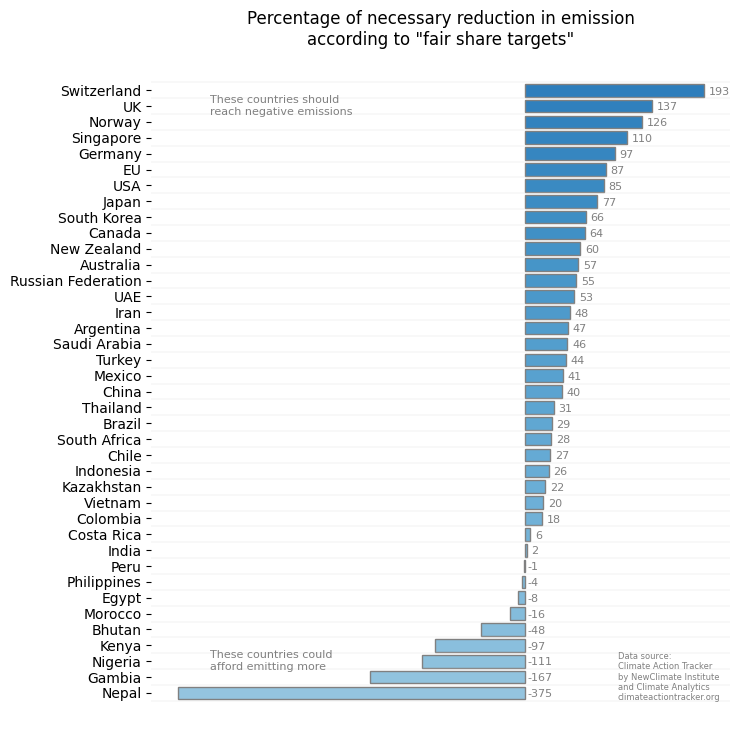

In [9]:
inds = np.array(reductionValue).argsort()
reductionCountrySorted=np.array(reductionCountry)[inds]
reductionValueSorted=np.array(reductionValue)[inds]

plt.figure(figsize=(7.5, 7.5))
colors = plt.cm.Blues(np.linspace(0.4, 0.7, len(reductionValueSorted)))

bars = plt.barh(reductionCountrySorted, reductionValueSorted, color=colors, edgecolor='gray')

# Add title and labels
plt.title('Percentage of necessary reduction in emission\naccording to "fair share targets"', fontsize=12 )

# Annotate the bars with the values
for i,bar in enumerate(bars):
    if reductionValueSorted[i]>0:
        plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height() / 2-0.08,
             f'{bar.get_width():.0f}', va='center', ha='left', color='gray', fontsize=8)
    else:
        plt.text(2 , bar.get_y() + bar.get_height() / 2 - 0.08,
             f'{bar.get_width():.0f}', va='center', ha='left', color='gray', fontsize=8)

for i in range(-1,len(bars)):
    plt.axhline(i+0.5,lw=0.2,color='lightgray')
plt.box(False)
plt.xticks([],[])
plt.xlabel('')
plt.ylabel('')

plt.text(100 , 1,
     'Data source:\nClimate Action Tracker\nby NewClimate Institute\nand Climate Analytics\nclimateactiontracker.org', 
         va='center', ha='left', color='gray', fontsize=6)

plt.text(-340 , len(bars)-2,
     'These countries should\nreach negative emissions', 
         va='center', ha='left', color='gray', fontsize=8)

plt.text(-340 , 2,
     'These countries could\nafford emitting more', 
         va='center', ha='left', color='gray', fontsize=8)


plt.tight_layout()
plt.savefig('fairshare.png',dpi=100)
plt.show()
